In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [11]:
import PySimpleGUI as sg    
from pykat import finesse
from pykat.commands import * 
import pykat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import math
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

In [12]:
def generate_kat_FPMI(dic_fpmi_ispds, dic_fpmi_advanced_setting):

    ###############################
    ### get variables from GUI ###
    
    ### Optic ###
    laser_power = dic_fpmi_advanced_setting["laser_power"]#source laser power
    
    ### DoF ###
    dof = dic_fpmi_advanced_setting["dof"]#CARM PRCL BS
    
    sweep_range_start = dic_fpmi_advanced_setting["sweep_range_start"]
    sweep_range_end = dic_fpmi_advanced_setting["sweep_range_end"]
    lin_or_log = dic_fpmi_advanced_setting["lin_or_log"]
    istransfunc = dic_fpmi_advanced_setting["istransfunc"]
    demod_phase_I = str(0+float(dic_fpmi_advanced_setting["demod_phase"]))
    demod_phase_Q = str(90+float(dic_fpmi_advanced_setting["demod_phase"]))
    #demod_num = dic_fpmi_advanced_setting["demod_num"]
    
    ###############################

    ### INF components ###
    input_finesse = """
    ### FPMI

    const f1 16.881M
    const f2 45.0159M

    # Input optics
    l i1 %s 0 n0
    s s_eo0 0 n0 n_eo1
    mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
    s s_eo1 0 n_eo2 n_eo3
    mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
    s s_eo2 0 n_eo4 n1

    # Michelson
    bs bs1 0.5 0.5 0 45 n1 n2 n3 n4
    s lx 26.6649 n3 nx1
    s ly 23.3351 n2 ny1


    # X arm
    m ITMX 0.996 0.004 0 nx1 nx2
    s sx1 3000 nx2 nx3
    m ETMX 0.99995 5e-06 0 nx3 nxtrans

    # Y arm
    m ITMY 0.996 0.004 90 ny1 ny2
    s sy1 3000 ny2 ny3
    m ETMY 0.99995 5e-06 90 ny3 nytrans

    """ % (laser_power)

    ### PDs location ###
    
    # demod_num
    # demod_phase #slider?
    pd0s_code = ""
    pd1s_code = ""
    pd2s_code = ""

    for key in dic_fpmi_ispds.keys():
        if dic_fpmi_ispds[key] == True:
            pd0s_code_add = """
            pd0 pd0_%s_I %s
            pd0 pd0_%s_Q %s
            """% (key,key,
                  key,key,
                  )
            pd0s_code = pd0s_code + pd0s_code_add # input finesse ni tyokusetu tasu
 
            pd1s_code_add = """
            pd1 pd1_%s_I1 $f1 %s %s
            pd1 pd1_%s_Q1 $f1 %s %s
            pd1 pd1_%s_I2 $f2 %s %s
            pd1 pd1_%s_Q2 $f2 %s %s
            """% (key, demod_phase_I, key,
                  key, demod_phase_Q, key,
                  key, demod_phase_I, key,
                  key, demod_phase_Q, key)
            pd1s_code = pd1s_code + pd1s_code_add
        
            pd2s_code_add ="""
            pd2 pd2_%s_I $f1 0 10 %s
            put pd2_%s_I f2 $x1
            pd2 pd2_%s_Q $f1 0 10 %s
            put pd2_%s_Q f2 $x1
            """% (key,key,
                  key,
                  key,key,
                  key)
            pd2s_code = pd2s_code + pd2s_code_add
            
    #pd2s_code = 
    """
            pd2 pd2_n1_I $f1 max 10 n1
            put pd2_n1_I f2 $x1
            """
    input_finesse += pd0s_code+pd1s_code+pd2s_code
    
    #+pd2s_code
    
    if(istransfunc==True):
        
        ### DoF ###
        if(dof=="DARM"):
            darm_sweep = """
        ## DARM ###
        fsig sig1 ETMX 10 0
        fsig sig2 ETMY 10 180
        xaxis sig1 f log .01 100 500
        #pd2 %s_I $f1 0 10 %s
        #put inphase f2 $x1
        yaxis lin abs:deg
            """
            input_finesse = input_finesse + darm_sweep

        elif(dof=="CARM"):
            carm_sweep = """
        fsig sig1 ETMX 10 0
        fsig sig2 ETMY 10 0
        #pd2 inphase $f1 max 10 nREFL
        xaxis sig1 f log .01 100 500
        #put inphase f2 $x1
        yaxis lin abs:deg
            """
            input_finesse = input_finesse + carm_sweep

        elif(dof=="BS"):
            bs_sweep = """
        fsig sig1 ETMX 10 0
        fsig sig2 ITMX 10 0 # sig1 zenbu
        fsig sig3 ETMY 10 180
        fsig sig4 ITMY 10 180
        xaxis sig1 f log .01 100 500
        #pd2 REFLI1 $f1 0 10 nREFL
        #pd2 REFLQ1 $f1 90 10 nREFL
        #put REFLI1 f2 $x1
        #put REFLQ1 f2 $x1
        yaxis lin abs
            """
            input_finesse = input_finesse + bs_sweep
        else:
            pass
        
    if(istransfunc==False):
      
        ### DoF ###

        if(dof=="DARM"):
            darm_sweep = """
        # DARM scan
        xaxis ETMX phi %s %s %s 500
        put* ETMY phi $mx1
        yaxis abs

            """ % (lin_or_log, dic_fpmi_advanced_setting["sweep_range_start"], dic_fpmi_advanced_setting['sweep_range_end'])
            input_finesse = input_finesse + darm_sweep

        elif(dof=="CARM"):
            carm_sweep = """
        # CARM scan
        xaxis* ETMX phi %s %s %s 500
        put* ETMY phi $x1
        yaxis abs
            """ % (lin_or_log,dic_fpmi_advanced_setting['sweep_range_start'],dic_fpmi_advanced_setting['sweep_range_end'])
            input_finesse = input_finesse + carm_sweep

        elif(dof=="BS"):
            bs_sweep = """
        # BS scan
        xaxis* ITMX phi %s %s %s 500
        put* ITMY phi $mx1
        put* ETMX phi $x1
        put* ETMY phi $mx1
        yaxis abs
            """ % (lin_or_log,dic_fpmi_advanced_setting['sweep_range_start'],dic_fpmi_advanced_setting['sweep_range_end'])
            input_finesse = input_finesse + bs_sweep
        else:
            pass

    code = input_finesse
    print(code)
    return code

In [13]:
sg.theme('Default1')

'Default1'

In [14]:
def collapse(layout, key):
    """
    Helper function that creates a Column that can be later made hidden, thus appearing "collapsed"
    :param layout: The layout for the section
    :param key: Key used to make this seciton visible / invisible
    :return: A pinned column that can be placed directly into your layout
    :rtype: sg.pin
    """
    return sg.pin(sg.Column(layout, key=key))

In [15]:
#section setting pd0/pd1/pd2
# pd0
fpmi_section0 = [
            [sg.Text('xaxis'),sg.Combo(('lin', 'log'),default_value='lin', size=(20, 1),key='fpmi_pd0_lin_or_log')], 
            [sg.Text('sweep range'),sg.Input(key='fpmi_pd0_sweep_range_start', default_text='-180', enable_events=True),
            sg.Text("to"),sg.Input(key='fpmi_pd0_sweep_range_end', default_text='180', enable_events=True)]
            ]
# pd1
fpmi_section1 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1(in_phase f1)', size=(5, 1), key='plot_in_phase_f1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(5, 1), key='plot_quadrature_phase_f1'),
            sg.Checkbox('I2(in_phase f2)', size=(5, 1), key='plot_in_phase_f2'),
            sg.Checkbox('Q2(quadrature_phase f1)', size=(5, 1), key='plot_quadrature_phase_f2')],
            [sg.Text('Demodulation_phase'),sg.Input(key='demod_phase', default_text='0', enable_events=True)],
            [sg.Text('xaxis'),sg.Combo(('lin', 'log'),default_value='lin', size=(20, 1),key='lin_or_log')], 
            [sg.Text('sweep range'),sg.Input(key='sweep_range_start', default_text='-180', enable_events=True),
            sg.Text("to"),sg.Input(key='sweep_range_end', default_text='180', enable_events=True)],
]
# pd2
fpmi_section2 = [[sg.Input('Input sec 1', key='-IN1-')],
            [sg.Input(key='-IN11-')],
            [sg.Button('Button section 1',  button_color='yellow on green'),
             sg.Button('Button2 section 1', button_color='yellow on green'),
             sg.Button('Button3 section 1', button_color='yellow on green')]]


In [16]:
tab1_layout =  [
                ]


In [17]:
#FPMI_tab
tab2_layout = [
                [sg.Image("./Fabry_Perot_MI_eom_drawing.png", key="imageContainer", size=(800,600))],#size=(800,600)
                [sg.Text('DoF'),sg.Combo(('DARM', 'CARM', 'BS'),default_value='DARM', size=(20, 1),key='dof')],
                ## PDs checkbox
                [sg.Text('check PDs')],
                [sg.Checkbox('REFL', size=(5, 1), key='n1'),sg.Checkbox('AS', size=(5, 1), key='n4'),
                sg.Checkbox('nytrans', size=(5, 1), key='nytrans'),sg.Checkbox('nxtrans', size=(5, 1), key='nxtrans'),
                sg.Checkbox('n2', size=(5, 1), key='n2'),sg.Checkbox('n3', size=(5, 1), key='n3'),
                sg.Checkbox('ny1', size=(5, 1), key='ny1'),sg.Checkbox('nx1', size=(5, 1), key='nx1'),
                sg.Checkbox('ny2', size=(5, 1), key='ny2'),sg.Checkbox('nx2', size=(5, 1), key='nx2'),
                sg.Checkbox('ny3', size=(5, 1), key='ny3'),sg.Checkbox('nx3', size=(5, 1), key='nx3'),
                ],
                [sg.Text('laser_power [W]'), sg.Input(key='laser_power', default_text='1')],
                ### RADIO BOX pd0/pd1/pd2
                [sg.Radio('scan(pd0)', "RADIO1", default=True, size=(10,1), key='isscan', enable_events=True),
                 sg.Radio('Demod_once(pd1)',"RADIO1", default=False, size=(10,1), key='isdemod_once', enable_events=True),
                 sg.Radio('Sensing_Matrix(pd2)', "RADIO1", default=False, size=(10,1), key='istransfunc', enable_events=True)],
                ### pd0_setting_section
                [collapse(fpmi_section0, 'pd0_setting_section')],
                ### pd1_settnig_section
                [collapse(fpmi_section1, 'pd1_setting_section')],
                ### pd2_setting_section
                [collapse(fpmi_section2, 'pd2_setting_section')],
                [sg.Button('Plot', button_color=('white', 'black'), key='event_FPMI')],
                ]

isdemod_once {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': True, 'nxtrans': True, 'n2': True, 'n3': True, 'ny1': True, 'nx1': True, 'ny2': True, 'nx2': True, 'ny3': True, 'nx3': True, 'laser_power': '1', 'isscan': False, 'isdemod_once': True, 'istransfunc': False, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': False, 'plot_quadrature_phase_f1': False, 'plot_in_phase_f2': False, 'plot_quadrature_phase_f2': False, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-180', 'sweep_range_end': '180', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}
istransfunc {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': True, 'nxtrans': True, 'n2': True, 'n3': True, 'ny1': True, 'nx1': True, 'ny2': True, 'nx2': True, 'ny3': True, 'nx3': True, 'laser_power': '1', 'isscan': False, 'isdemod

istransfunc {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': True, 'nxtrans': True, 'n2': True, 'n3': True, 'ny1': True, 'nx1': True, 'ny2': True, 'nx2': True, 'ny3': True, 'nx3': True, 'laser_power': '1', 'isscan': False, 'isdemod_once': False, 'istransfunc': True, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': False, 'plot_quadrature_phase_f1': False, 'plot_in_phase_f2': False, 'plot_quadrature_phase_f2': False, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-180', 'sweep_range_end': '180', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}
isdemod_once {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': True, 'nxtrans': True, 'n2': True, 'n3': True, 'ny1': True, 'nx1': True, 'ny2': True, 'nx2': True, 'ny3': True, 'nx3': True, 'laser_power': '1', 'isscan': False, 'isdemod

isdemod_once {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': True, 'nxtrans': True, 'n2': True, 'n3': True, 'ny1': True, 'nx1': True, 'ny2': True, 'nx2': True, 'ny3': True, 'nx3': True, 'laser_power': '1', 'isscan': False, 'isdemod_once': True, 'istransfunc': False, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': True, 'plot_quadrature_phase_f1': True, 'plot_in_phase_f2': True, 'plot_quadrature_phase_f2': True, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-180', 'sweep_range_end': '180', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}
event_FPMI {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': True, 'nxtrans': True, 'n2': True, 'n3': True, 'ny1': True, 'nx1': True, 'ny2': True, 'nx2': True, 'ny3': True, 'nx3': True, 'laser_power': '1', 'isscan': False, 'isdemod_once

100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /home/controls/miniconda2/envs/mifsim/bin/kat

Finished in 0.207129 seconds


/home/controls/miniconda2/envs/mifsim/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


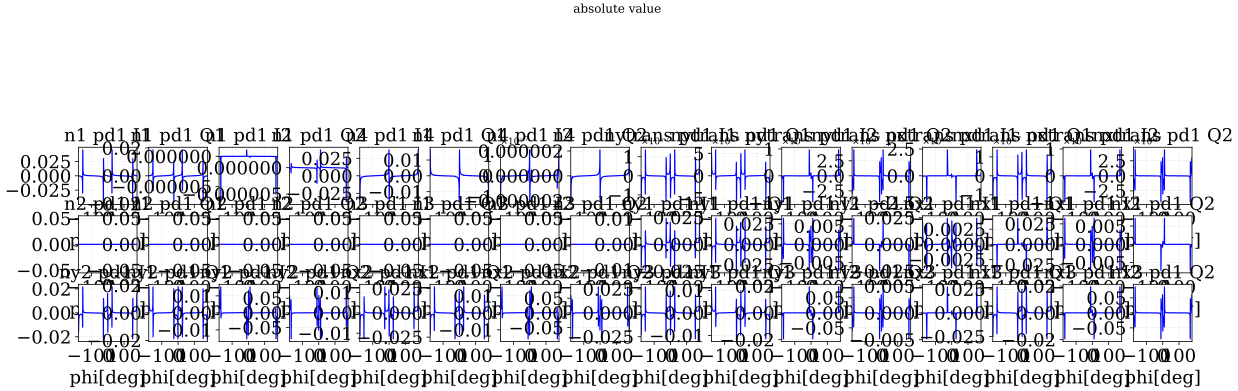

istransfunc {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': True, 'nxtrans': True, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': False, 'isdemod_once': False, 'istransfunc': True, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': True, 'plot_quadrature_phase_f1': True, 'plot_in_phase_f2': True, 'plot_quadrature_phase_f2': True, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-180', 'sweep_range_end': '180', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}
isdemod_once {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': True, 'nxtrans': True, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': Fal

istransfunc {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': True, 'nxtrans': True, 'n2': True, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': False, 'isdemod_once': False, 'istransfunc': True, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': True, 'plot_quadrature_phase_f1': True, 'plot_in_phase_f2': True, 'plot_quadrature_phase_f2': True, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-180', 'sweep_range_end': '180', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}
isdemod_once {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': True, 'nxtrans': True, 'n2': True, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': False

event_FPMI {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': False, 'nxtrans': False, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': False, 'isdemod_once': True, 'istransfunc': False, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': True, 'plot_quadrature_phase_f1': True, 'plot_in_phase_f2': True, 'plot_quadrature_phase_f2': True, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-1', 'sweep_range_end': '1', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}

    ### FPMI

    const f1 16.881M
    const f2 45.0159M

    # Input optics
    l i1 1 0 n0
    s s_eo0 0 n0 n_eo1
    mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
    s s_eo1 0 n_eo2 n_eo3
    mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
    s s_eo2 0 n_eo4 n1

    # Michelson
    bs bs1 0

100% | ETA:  0:00:00 | Calculating                                             

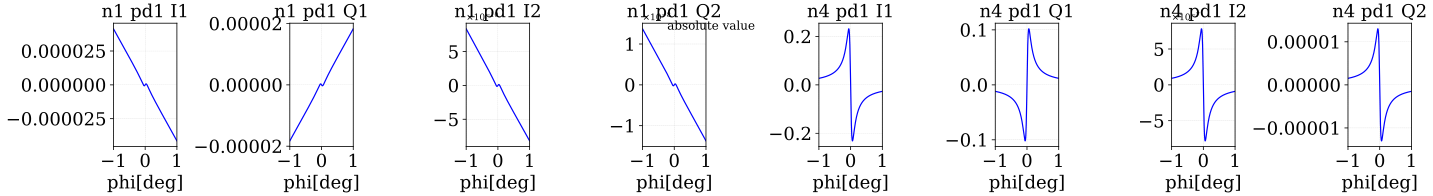

isscan {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': False, 'nxtrans': False, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': True, 'isdemod_once': False, 'istransfunc': False, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': True, 'plot_quadrature_phase_f1': True, 'plot_in_phase_f2': True, 'plot_quadrature_phase_f2': True, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-1', 'sweep_range_end': '1', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}
event_FPMI {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': False, 'nxtrans': False, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': True, 'isd

100% | ETA:  0:00:00 | Calculating                                             

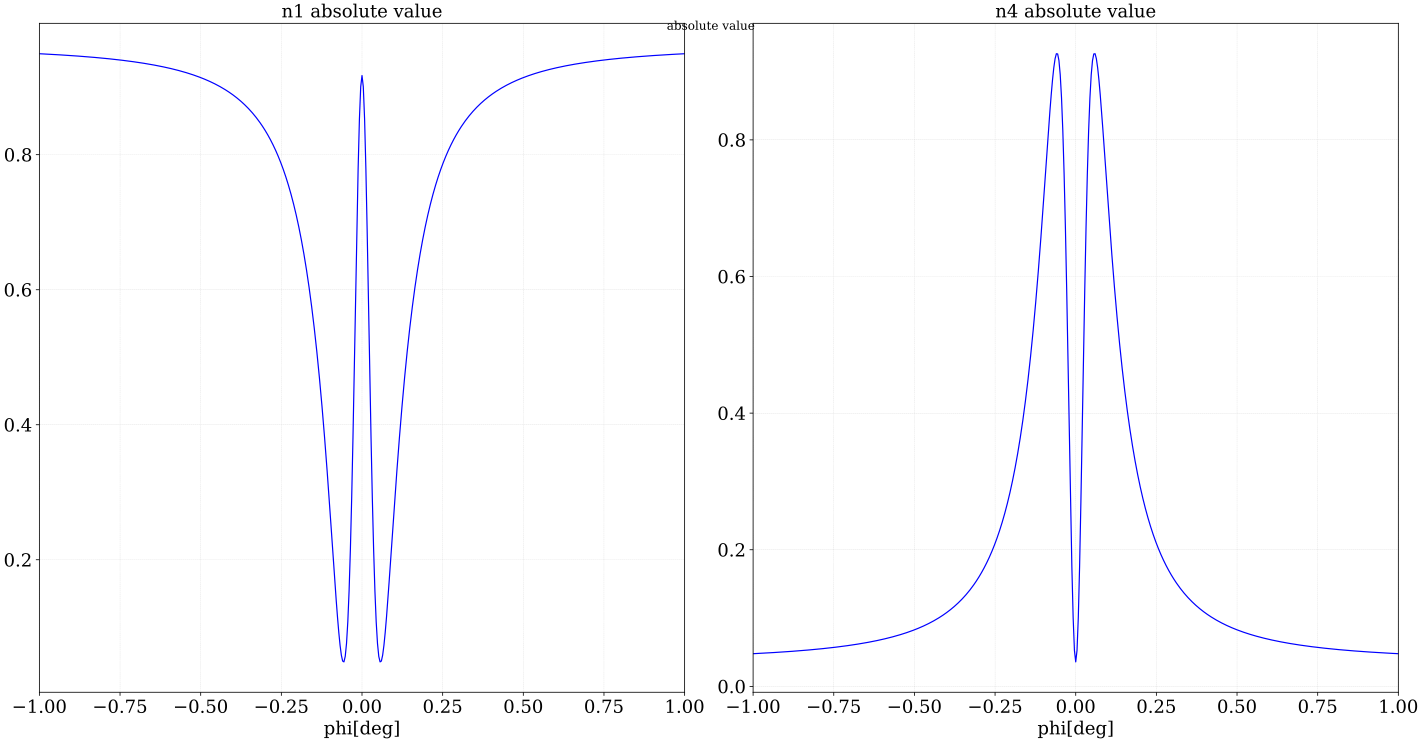

isdemod_once {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': False, 'nxtrans': False, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': False, 'isdemod_once': True, 'istransfunc': False, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': True, 'plot_quadrature_phase_f1': True, 'plot_in_phase_f2': True, 'plot_quadrature_phase_f2': True, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-1', 'sweep_range_end': '1', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}
sweep_range_start {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': False, 'nxtrans': False, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan

100% | ETA:  0:00:00 | Calculating                                             

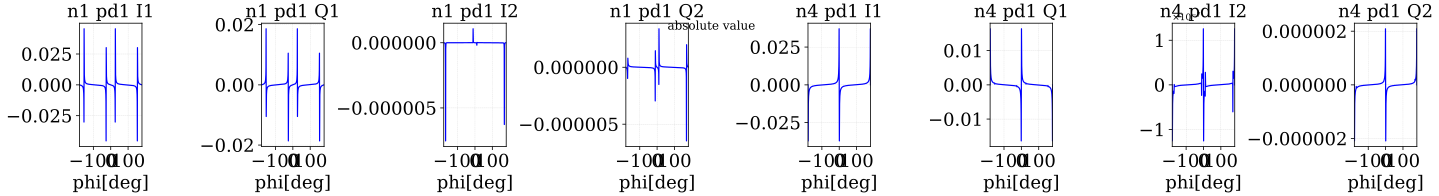

isscan {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': False, 'nxtrans': False, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': True, 'isdemod_once': False, 'istransfunc': False, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': True, 'plot_quadrature_phase_f1': True, 'plot_in_phase_f2': True, 'plot_quadrature_phase_f2': True, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-180', 'sweep_range_end': '180', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}
event_FPMI {'output_kat': False, 'output_plotdata': False, 'dof': 'DARM', 'n1': True, 'n4': True, 'nytrans': False, 'nxtrans': False, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': True, 

100% | ETA:  0:00:00 | Calculating                                             

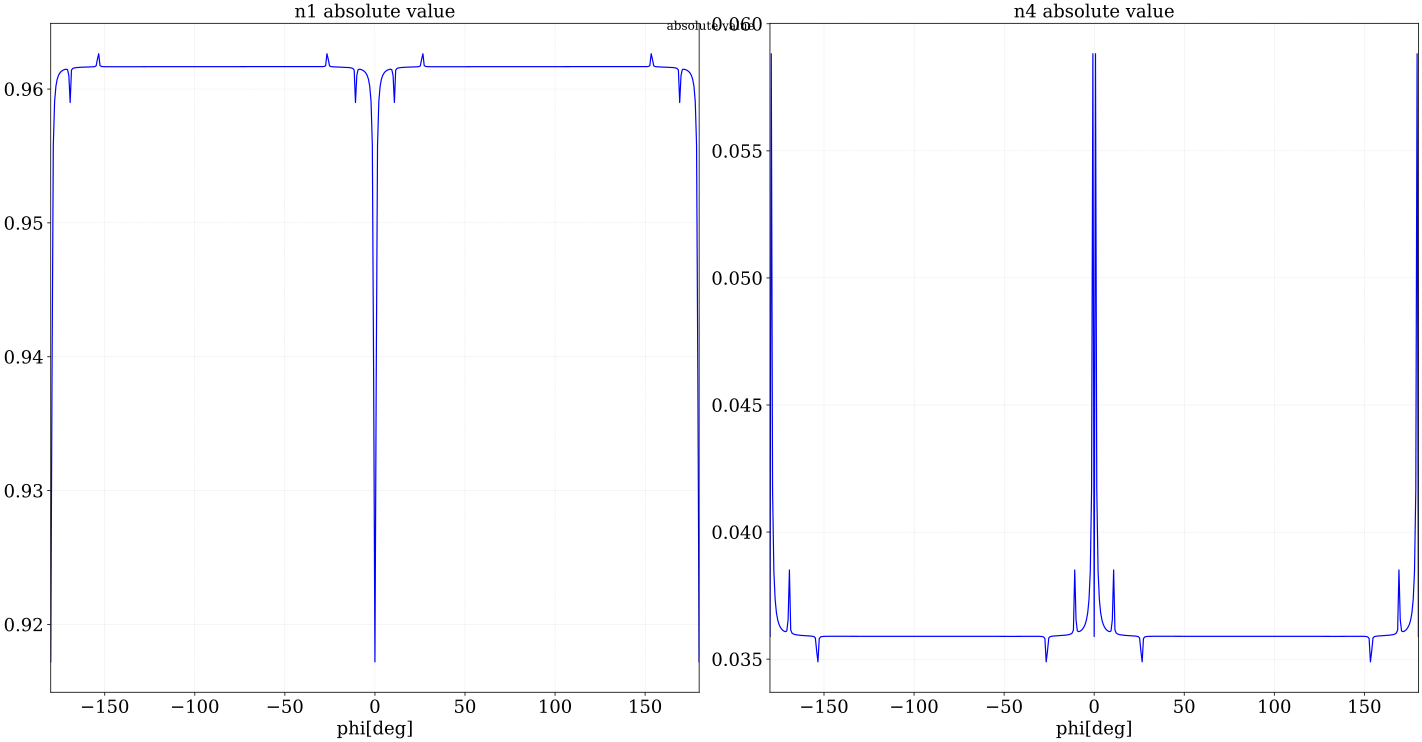

event_FPMI {'output_kat': False, 'output_plotdata': False, 'dof': 'BS', 'n1': True, 'n4': True, 'nytrans': False, 'nxtrans': False, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': True, 'isdemod_once': False, 'istransfunc': False, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': True, 'plot_quadrature_phase_f1': True, 'plot_in_phase_f2': True, 'plot_quadrature_phase_f2': True, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-180', 'sweep_range_end': '180', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}

    ### FPMI

    const f1 16.881M
    const f2 45.0159M

    # Input optics
    l i1 1 0 n0
    s s_eo0 0 n0 n_eo1
    mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
    s s_eo1 0 n_eo2 n_eo3
    mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
    s s_eo2 0 n_eo4 n1

    # Michelson
    bs bs1

100% | ETA:  0:00:00 | Calculating                                             

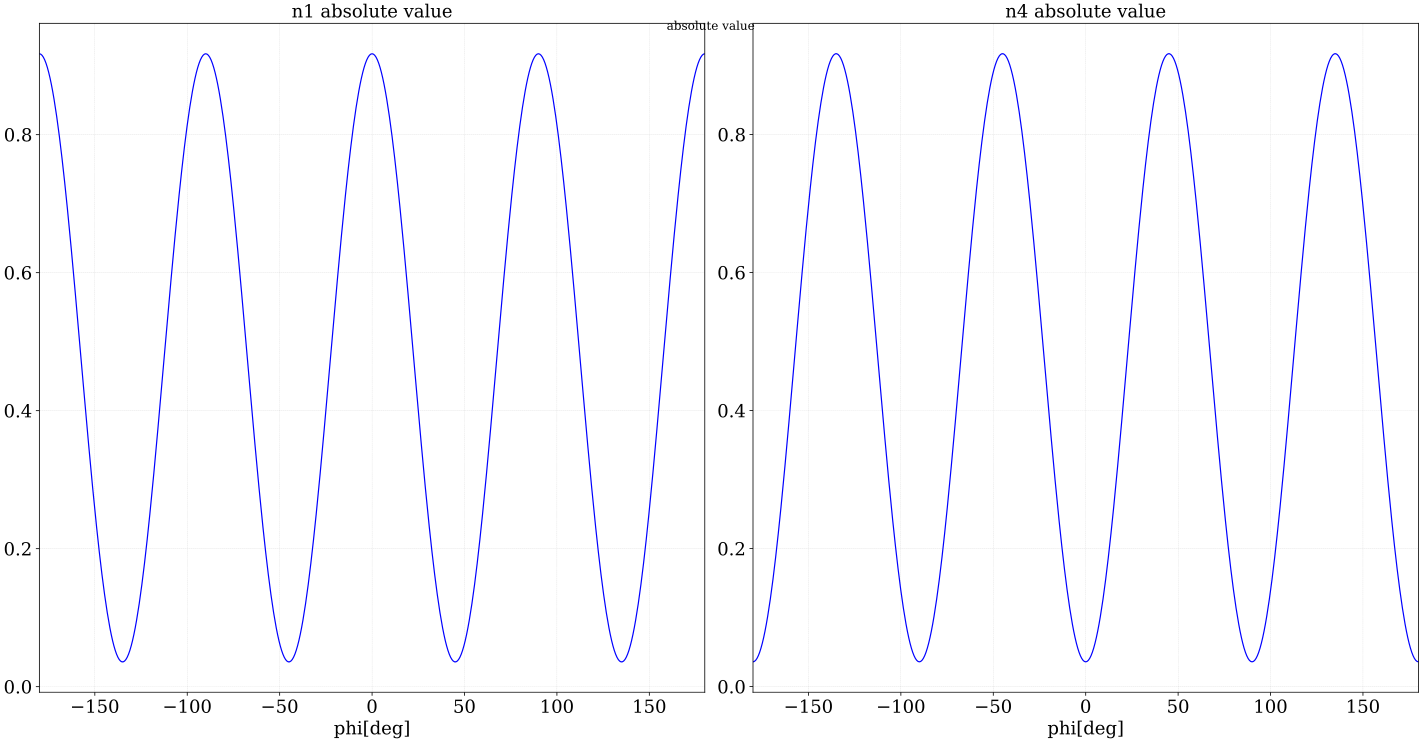

isdemod_once {'output_kat': False, 'output_plotdata': False, 'dof': 'BS', 'n1': True, 'n4': True, 'nytrans': False, 'nxtrans': False, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': False, 'isdemod_once': True, 'istransfunc': False, 'fpmi_pd0_lin_or_log': 'lin', 'fpmi_pd0_sweep_range_start': '-180', 'fpmi_pd0_sweep_range_end': '180', 0: None, 'plot_in_phase_f1': True, 'plot_quadrature_phase_f1': True, 'plot_in_phase_f2': True, 'plot_quadrature_phase_f2': True, 'demod_phase': '0', 'lin_or_log': 'lin', 'sweep_range_start': '-180', 'sweep_range_end': '180', 1: None, '-IN1-': 'Input sec 1', '-IN11-': '', 2: None, 3: 'FPMI_TAB'}
istransfunc {'output_kat': False, 'output_plotdata': False, 'dof': 'BS', 'n1': True, 'n4': True, 'nytrans': False, 'nxtrans': False, 'n2': False, 'n3': False, 'ny1': False, 'nx1': False, 'ny2': False, 'nx2': False, 'ny3': False, 'nx3': False, 'laser_power': '1', 'isscan': Fal

100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /home/controls/miniconda2/envs/mifsim/bin/kat

Finished in 0.420492 seconds


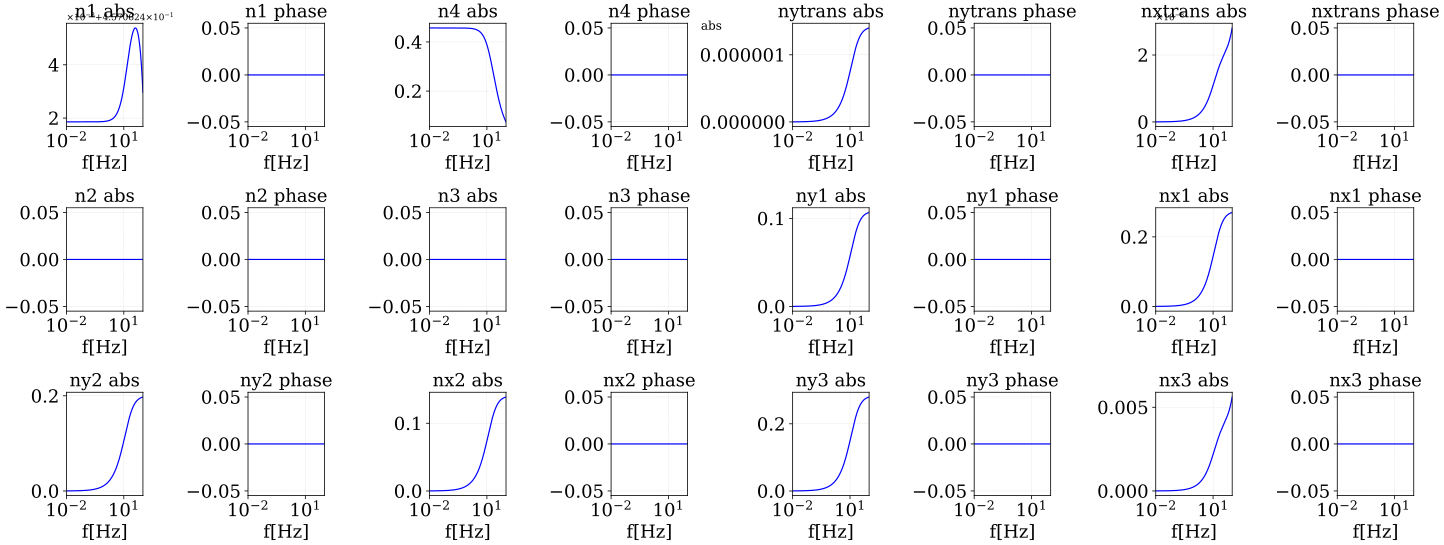

In [ ]:
layout = [[sg.Text('Which data you output?')],
          [sg.Checkbox('kat file', size=(5, 1), key='output_kat'), sg.Checkbox('plotdata', size=(5, 1), key='output_plotdata')],
          [sg.TabGroup([[sg.Tab('Tab 1', tab1_layout), sg.Tab('FPMI_TAB', tab2_layout)]])]
         ] 

window = sg.Window('My window with tabs', layout, default_element_size=(12,1), finalize=True)    

fname_output=""
fname_kat=""
check = False

while True:    
    if(check==False):
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
        check = True
    event, values = window.read()

    print(event,values)
    if event == sg.WIN_CLOSED:     # if all windows were closed
        break
    if event == "Exit":           # always,  always give a way out!   # atode kesu 
        break        
    if event == 'sweep_range_start' and values['sweep_range_start'] and values['sweep_range_start'][-1] not in ('0123456789.-'):
        window['sweep_range_start'].update(values['sweep_range_start'][:-1])
    if event == 'sweep_range_end' and values['sweep_range_end'] and values['sweep_range_end'][-1] not in ('0123456789.-'):
        window['sweep_range_end'].update(values['sweep_range_end'][:-1])
    ### visible/invisible advanced setting
    if event == 'isscan':
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
    if event == 'isdemod_once':
        window['pd0_setting_section'].update(visible=False)
        window['pd1_setting_section'].update(visible=True)
        window['pd2_setting_section'].update(visible=False)
    if event == "istransfunc":
        window['pd0_setting_section'].update(visible=False)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=True)
    if event == "event_FPMI":           # FPMI
        ###############################
        ### get variables from GUI ###
        ###############################

        ### Optic ###
        ##laser_power = values['laser_power']#source laser power
    
        ### what INF ###
        ##what_inf = values['what_inf']

        ### PD location ###
        dic_fpmi_ispds = {
            ### PDs
            "n1":values['n1'],#bool REFL
            "n4":values['n4'],#bool AS
            "nytrans":values['nytrans'],#bool
            "nxtrans":values['nxtrans'],#bool
            "n2":values['n2'],#bool
            "n3":values['n3'],#bool
            "ny1":values['ny1'],#bool
            "nx1":values['nx1'],#bool
            "ny2":values['ny2'],#bool
            "nx2":values['nx2'],#bool
            "ny3":values['ny3'],#bool
            "nx3":values['nx3'],#bool
        }
        dic_fpmi_advanced_setting = {
            ### DoF
            "dof":values['dof'],
            ### pd0/pd1/pd2?
            "isscan":values['isscan'],#bool
            "isdemod_once":values['isdemod_once'],#bool
            "istransfunc":values['istransfunc'],#bool
            ### advanced setting
            "laser_power":values['laser_power'],#str
            "lin_or_log":values['lin_or_log'],#str
            "sweep_range_start":values['sweep_range_start'],#str #beg
            "sweep_range_end":values['sweep_range_end'],#str
            "demod_phase":values['demod_phase'],#str 
            #"demod_num":values['demod_num'],
        }
        # 
        ########
        #start_deg = values['start_deg']
        #end_deg = values['end_deg']  
        ########
        
        kat = finesse.kat()
        code = generate_kat_FPMI(dic_fpmi_ispds, dic_fpmi_advanced_setting)
        kat.parse(code)
        out = kat.run()
        
        ### scan
        if(values['isscan']==True):
            # 
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle("absolute value")
            plotnum = 0
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            vh_plotnum = math.ceil(math.sqrt(plotnum))
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        plt.subplot(vh_plotnum,vh_plotnum,i+1) #Axes
                        plt.plot(out.x, out["pd0_%s_I" % key])
                        #plt.ylabel('%s' % key)
                        #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s absolute value' % key, fontsize=18)
                        plt.tick_params(labelsize=18)
                        i += 1
            plt.tight_layout()
        ### demod once (pd1)
        if(values['isdemod_once']==True):
            # 
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle("absolute value")
            plotnum = 0
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                ###############################################
                ### この辺上手いやり方よくわからない
                j = 0
                if values['plot_in_phase_f1'] == True:
                    j += 1
                if values['plot_quadrature_phase_f1'] == True:
                    j += 1
                if values['plot_in_phase_f2'] == True:
                    j += 1
                if values['plot_quadrature_phase_f2'] == True:
                    j += 1
                ###############################################
                #plotの横の数
                vh_plotnum = j*math.ceil(math.sqrt(plotnum))
                #plotの縦の数
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        
                        if values['plot_in_phase_f1'] == True:
                            plt.subplot(vh_plotnum,vh_plotnum,i+1) #Axes
                            plt.plot(out.x, out["pd1_%s_I1" % key])#IorQ? I1orI2?
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s pd1 I1' % key, fontsize=18)
                            plt.tick_params(labelsize=18)
                        if values['plot_quadrature_phase_f1'] == True:
                            plt.subplot(vh_plotnum,vh_plotnum,i+2) #Axes
                            plt.plot(out.x, out["pd1_%s_Q1" % key])#IorQ? I1orI2?
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s pd1 Q1' % key, fontsize=18)
                            plt.tick_params(labelsize=18)
                        if values['plot_in_phase_f2'] == True:
                            plt.subplot(vh_plotnum,vh_plotnum,i+3) #Axes
                            plt.plot(out.x, out["pd1_%s_I2" % key])#IorQ? I1orI2?
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s pd1 I2' % key, fontsize=18)
                            plt.tick_params(labelsize=18)
                        if values['plot_quadrature_phase_f2'] == True:
                            plt.subplot(vh_plotnum,vh_plotnum,i+4) #Axes
                            plt.plot(out.x, out["pd1_%s_Q2" % key])#IorQ? I1orI2?
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s pd1 Q2' % key, fontsize=18)
                            plt.tick_params(labelsize=18)
                        i += j
            plt.tight_layout()
        ### sensmat(pd2)
        if(values['istransfunc']==True):
            # abs
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle("abs")
            plotnum = 0
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            vh_plotnum = 2*math.ceil(math.sqrt(plotnum)) # abs+phase
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        
                        plt.subplot(vh_plotnum,vh_plotnum,i+1) #Axes
                        plt.semilogx(out.x, out["pd2_%s_I" % key])
                        #plt.ylabel('%s' % key)
                        #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s abs' % key, fontsize=18)
                        plt.tick_params(labelsize=18)
                        
                        plt.subplot(vh_plotnum,vh_plotnum,i+2) #Axes
                        plt.semilogx(out.x, np.angle(out["pd2_%s_I" % key]))
                        #plt.ylabel('%s' % key)
                        #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s phase' % key, fontsize=18)
                        plt.tick_params(labelsize=18)
                        
                        i += 2
            plt.tight_layout()

        plt.show()
        
        if values['output_kat'] == True:
            kat=code
            fname_kat = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(("ALL Files", "*.txt"),))

            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_kat)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])
            
        if values['output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
            kat = out
            
            
            
            try:
                f = open(fname_plotdata, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_plotdata)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])
            
window.close()         

In [10]:
        if values['output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
            kat = out
            try:
                f = open(fname_plotdata, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_plotdata)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])

TypeError: 'NoneType' object is not subscriptable

In [ ]:
n_plots = len(....keys()
i=0
for key in ....keys()
    plt.subplot(n_plots, 2, i)
    plt.plot(out.x, out[key])
    i=i+1

In [ ]:
print(out)
x_split_list = out.xlabel.split()
print(x_split_list[0])
print(x_split_list[1])
print(x_split_list[2])